# Introduction

The idea of this project is to generate a dataset of electric vehicle driving using simulation. The dataset will be published in many plateformes as kaggle and github to be accessible by others sudents / data scoentist. <br>
For this purpose, we will start by preparing the data (NEDC / WLTP and other driving data). In the seconde time we will discovering the data by some plots.

<img src='../otherFiles/projectCoverPicture.png'>

## Newton's second law

The figure below show the forces applied to the vehicle

<img src='../otherFiles/car_img.png'>

The Newton's second law applied to the vehicle: see above
 
$$
\begin{align*}
 F_x &= m \frac{dv}{dt}= Thrust - (Drag + m.g.sin(α) + Rolling)\\
& with: Thrust = Torque . wheelRadius
\end{align*}
$$


## Abbreviation & keywords

**Abbreviation**

Below some abbreviation that well be used in this project

* EV : Electric vehicle
* SOC : State of charge 
* Batt : Battery
* INV : Inverter
* NEDC : New European Driving Cycle
* WLTC : Worldwide harmonized Light vehicles Test procedure Cycle

**Keywords**

EV simulation, Matlab, Simulink, WLTP , NEDC, EV Dataset, Electric vehicle dataset, HV battery, EV Autonomy, electrical motor, Thrust, car drag, wheel rolling, Newton's second law, Highway driving

# Table of contents

# Matlab / Simulink

## Simulation hypotheses

## Simulink

## Simulation parameters

# NEDC vs WLTC Cycles

## Import of the libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy import interpolate
import scipy

In [129]:
## Show all columns of a df
pd.set_option('display.max_columns', None)

## NEDC vs WLTC 

**Read data**

In [131]:
NEDC=pd.read_csv(r'../data/raw/NEDC.csv')
WLTC=pd.read_csv(r'../data/processed/WLTC_Class_3_vehicles_V2.csv')
NEDC.head(2)

,time,kmph
0,0,0
1,11,0


**Plot the two cycles**

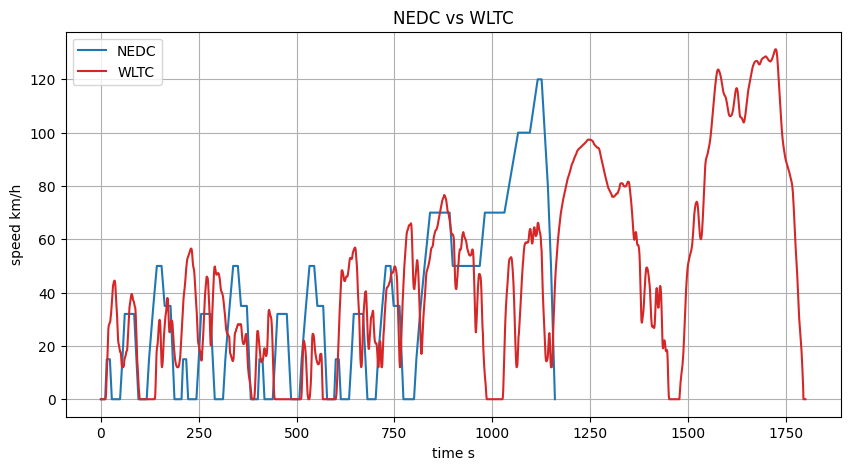

In [34]:
# Color plot 
r='#b7190f'
b='#26619c'
# Create a new figure
fig = plt.figure(figsize=(10,5))

plt.plot(NEDC.time,NEDC.kmph,label='NEDC',c='C0')
plt.plot(WLTC.time,WLTC.kmph,label='WLTC',c='C3')
plt.title('NEDC vs WLTC')
plt.xlabel('time s')
plt.ylabel('speed km/h')
plt.legend()
plt.grid()
#plt.savefig(r'../otherFiles/figures/NEDC_WLTC.png')
plt.show()

We can see that the WLTC is more realistic than the NEDC

# Simulation element tests

## Motor

In [35]:
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/motor_test_res.mat')

**Torque vs speed**

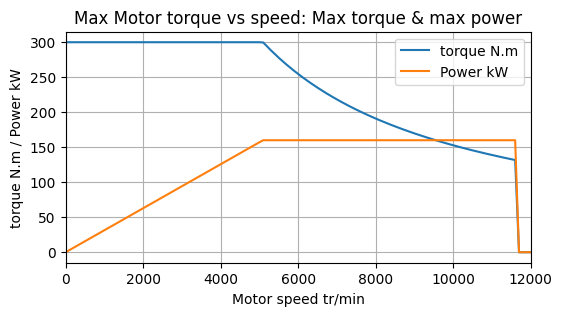

In [36]:
# motor speed rpm
motor_speed_rpmPM=mat['motor_speed_rpm']
motor_speed_rpmPM=motor_speed_rpmPM[0][0][1][0][0][0].flatten()

# motor torque
motor_torquePM=mat['motor_torque']
motor_torquePM=motor_torquePM[0][0][1][0][0][0].flatten()

# convert to dataFrame
dfm=pd.DataFrame(motor_speed_rpmPM,columns=['motor_speed_rpm'])
dfm['motor_torque']=motor_torquePM

# Power
powerKwPM=motor_torquePM*(motor_speed_rpmPM*2*np.pi/60)/1000


# Plot
figure(figsize=(6, 3))
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m')
plt.plot(motor_speed_rpmPM,powerKwPM,label='Power kW')
plt.grid()
plt.ylabel('torque N.m / Power kW')
plt.xlabel('Motor speed tr/min')
plt.title('Max Motor torque vs speed: Max torque & max power')
plt.xlim([0,12000])
plt.legend()
plt.show()

For this simulation, we will use the simple strategy: max torque util the power reached its max, and after that the power will be limited to its max
<br> 
In the real control, the torque / speed is close to this cuve, but with a more complicated vector control strategy

**Comparaison between the torque of the electrical Megane-E 220Hp and the gasoline Volvo C30 T5 220Hp**

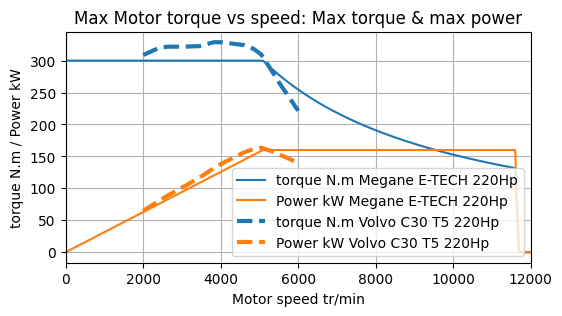

In [37]:
# The below data is extracted from the graph in the link below: 
# https://en.bsr.se/tuning-kits/t/947/volvo-c30-t5-220hp-2007-2013-b-5254-t3
volvo='''2000	308.7209302
2255.578093	315.6976744
2385.395538	319.1860465
2624.74645	321.8023256
3050.709939	321.8023256
3448.275862	322.6744186
3829.614604	328.7790698
4016.227181	328.7790698
4356.997972	326.1627907
4588.235294	324.4186047
4851.926978	318.3139535
5046.653144	309.5930233
5342.799189	281.6860465
5513.184584	265.1162791
5805.273834	238.9534884
6000	221.5116279'''
volvo=volvo.split('\n')
volvo=[x.split('\t') for x in volvo]
volvo=np.array(volvo).T.astype(float)
rpm_vol=volvo[0]
torq_vol=volvo[1]
power_vol=torq_vol*(rpm_vol *2*np.pi/60)/1000

# Plot
figure(figsize=(6, 3))
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C0')
plt.plot(motor_speed_rpmPM,powerKwPM,label='Power kW Megane E-TECH 220Hp',c='C1')

plt.plot(rpm_vol,torq_vol,linestyle="--",linewidth=3,\
         label='torque N.m Volvo C30 T5 220Hp',c='C0')
plt.plot(rpm_vol,power_vol,linestyle="--",linewidth=3,\
         label='Power kW Volvo C30 T5 220Hp',c='C1')

plt.grid()
plt.ylabel('torque N.m / Power kW')
plt.xlabel('Motor speed tr/min')
plt.title('Max Motor torque vs speed: Max torque & max power')
plt.xlim([0,12000])
plt.legend()
plt.show()

we can see that the Megane-E 220Hp and the gasoline Volvo C30 T5 220 Hp have the same peak power, but the speed range of the max torque is very short for the gasoline, because of that the conventional cars use a gearbox to adapt the speed, and the electrical vehicle use just a one level reductor.

## Battery

In [38]:
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/battery_test_res.mat')

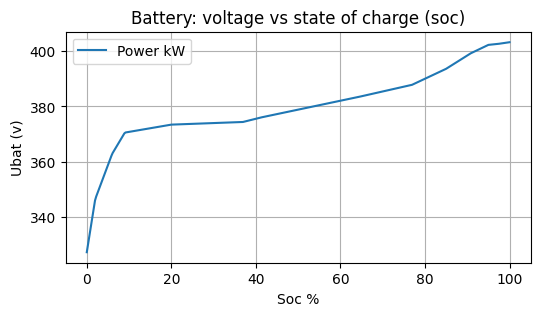

In [39]:
# battery Ubat
battery_Ubat=mat['battery_Ubat']
battery_Ubat=battery_Ubat[0][0][1][0][0][0].flatten()

# battery SOC
battery_soc=mat['battery_soc']
battery_soc=battery_soc[0][0][1][0][0][0].flatten()

# Plot
figure(figsize=(6, 3))
plt.plot(battery_soc,battery_Ubat,label='Power kW')
plt.grid()
plt.ylabel('Ubat (v)')
plt.xlabel('Soc %')
plt.title('Battery: voltage vs state of charge (soc)')
plt.legend()
plt.show()

## Body 

In [40]:
# read matlab data 
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/body_test_res.mat')

**Plot**

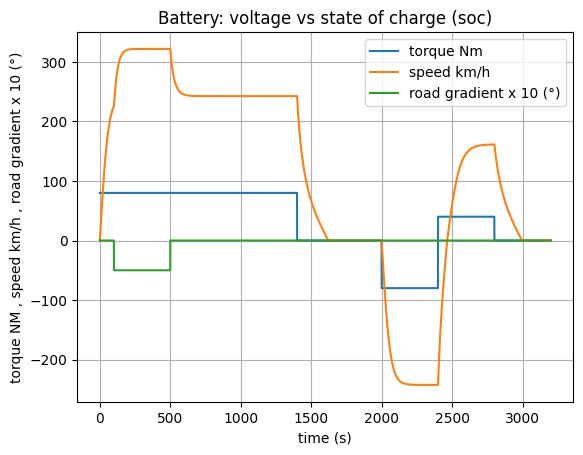

In [41]:
# time 
time  = mat['body_test_torque'][0][0][0].flatten()

# torque
body_test_torque=mat['body_test_torque']
body_test_torque=body_test_torque[0][0][1][0][0][0].flatten()

# speed 
body_test_speedMeas=mat['body_test_speedMeas']
body_test_speedMeas=body_test_speedMeas[0][0][1][0][0][0].flatten()

# speed 
body_test_roadGrad=mat['body_test_roadGrad']
body_test_roadGrad=180*body_test_roadGrad[0][0][1][0][0][0].flatten()/np.pi

plt.plot(time,body_test_torque,label='torque Nm')
plt.plot(time,body_test_speedMeas,label='speed km/h')
plt.plot(time,10*body_test_roadGrad,label='road gradient x 10 (°)')

plt.ylabel('torque NM , speed km/h , road gradient x 10 (°)')
plt.xlabel('time (s)')
plt.title('Battery: voltage vs state of charge (soc)')
plt.grid()
plt.legend()
plt.show()

## PI regulator, speed controller 

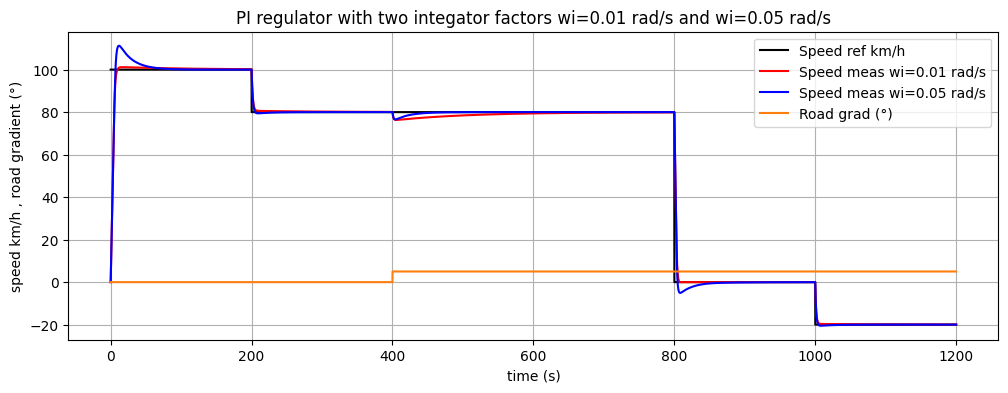

In [42]:
# read matlab data for wi=0.01 rad/s
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/pi_regulator_wi_0.01.mat')


# time 
time  = mat['reg_kmph_ref'][0][0][0].flatten()

# road gradient
road_grad  = 180*mat['road_grad'][0][0][1][0][0][0].flatten()/np.pi

# Speed ref
reg_kmph_ref=mat['reg_kmph_ref'][0][0][1][0][0][0].flatten()

# speed measurement for wi=0.01 rad/s
reg_kmph_meas_w0_01=mat['reg_kmph_meas'][0][0][1][0][0][0].flatten()

# read matlab data for wi=0.01 rad/s
mat = scipy.io.loadmat('../matlabFiles/testSubSystems/pi_regulator_wi_0.05.mat')

# speed measurement for wi=0.05 rad/s
reg_kmph_meas_w0_05=mat['reg_kmph_meas'][0][0][1][0][0][0].flatten()

# the regulator output 
reg_pi_output=mat['reg_pi_output'][0][0][1][0][0][0].flatten()

# Plot
figure(figsize=(12, 4))
plt.plot(time,reg_kmph_ref,label='Speed ref km/h',c='k')
plt.plot(time,reg_kmph_meas_w0_01,label='Speed meas wi=0.01 rad/s',c='r')
plt.plot(time,reg_kmph_meas_w0_05,label='Speed meas wi=0.05 rad/s',c='b')
plt.plot(time,road_grad,label='Road grad (°)',c='C1')
#plt.plot(time,20*reg_pi_output,label='regulator output',c='g')

plt.ylabel('speed km/h , road gradient (°)')
plt.xlabel('time (s)')
plt.title('PI regulator with two integator factors wi=0.01 rad/s and wi=0.05 rad/s')
plt.grid()
plt.legend()
plt.show()

We will conserve the integrator parameter wi=0.05 rad/s, because it give a best result in WLTC cycle. 
<br>
in fact, in the real life we can use the soft start, we can use reference with a sloop and not a perfect step 

# Driving simulation WLTC / NEDC/ Heighway ...

In [43]:
# This dictionary will be used to store autonomy of each cycle/driving
dic_auto={}

## WLTC Cycle

**Read the matlab/simulink results**

In [44]:
mat = scipy.io.loadmat('../matlabFiles/WLTC/WLTC_results.mat')

**Select only variables that start with 'tws_...'**

In [45]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [46]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfwltc=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfwltc[c]=value
    
# Display the head of the DF
dfwltc.head(2)

,time,tws_I_bat_ev,tws_Power_AC_ev,tws_Power_DC_ev,tws_Power_meca_ev,tws_Power_wheel_ev,tws_Ubat_ev,tws_acceleration_break,tws_acceleration_ev,tws_battery_power,...,tws_kmph_meas,tws_kmph_ref,tws_loss_INV_ev,tws_loss_batt_ev,tws_loss_body_ev,tws_loss_motor_ev,tws_road_grad,tws_soc_ev,tws_time,tws_torque_motor_ev
0,0.0,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,216000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,100.0,0.0,0.0
1,0.5,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,216000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,100.0,0.5,0.0


**Plot the speed: ref and measurement**

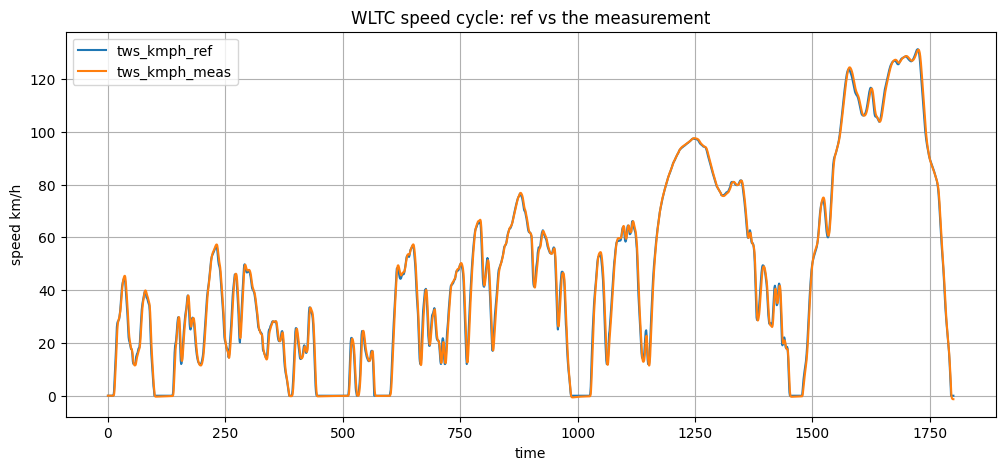

In [47]:
dfwltc.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('WLTC speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

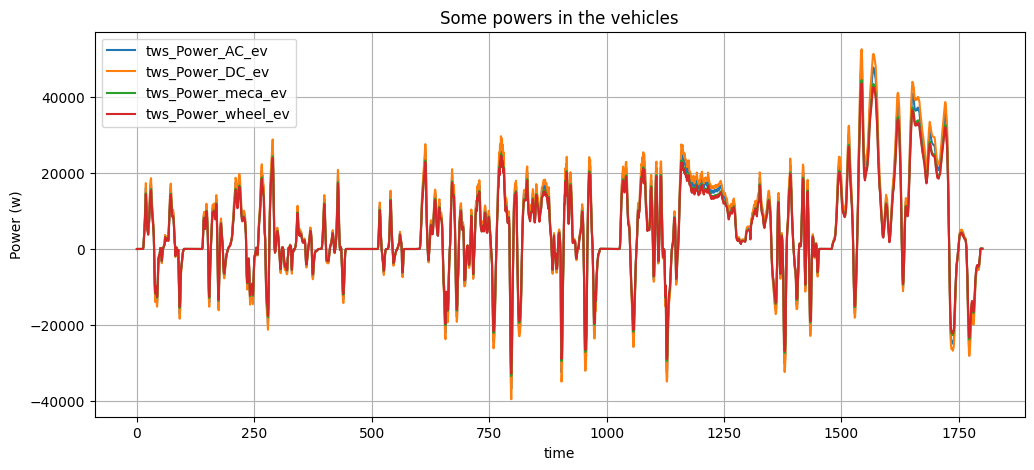

In [48]:
dfwltc.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [49]:
dfwltc.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

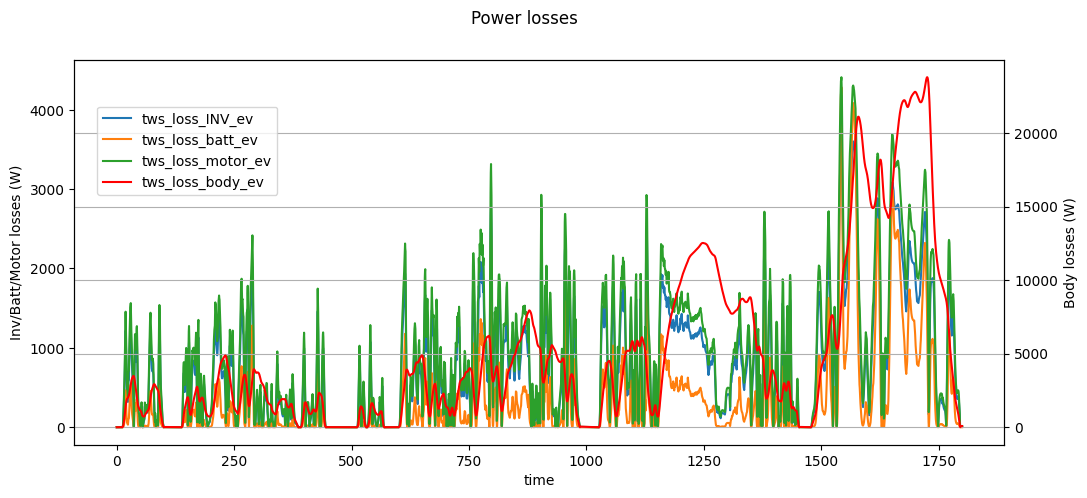

In [50]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfwltc.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfwltc.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

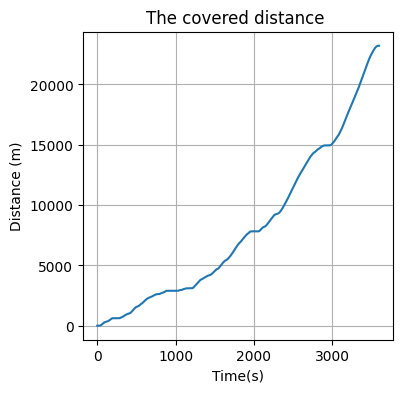

In [51]:
dfwltc[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [52]:
delta_soc=dfwltc['tws_soc_ev'].iloc[0]-dfwltc['tws_soc_ev'].iloc[-1]
delta_dist=dfwltc['tws_distance_ev'].iloc[-1]-dfwltc[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the WLTC cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the WLTC cycle is:  456.96 km
The autonomy calculated by matlab is:  456.99 km


In [53]:
# Store the autonomy in the dic_auto dictionary
dic_auto['wltc']=autonomy

**Calculate the RPM**

In [54]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfwltc['tws_rpm']=dfwltc['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

In [55]:
x=motor_speed_rpmPM.tolist()
xPM=x+x
yPM=motor_torquePM.tolist()+(-motor_torquePM).tolist()

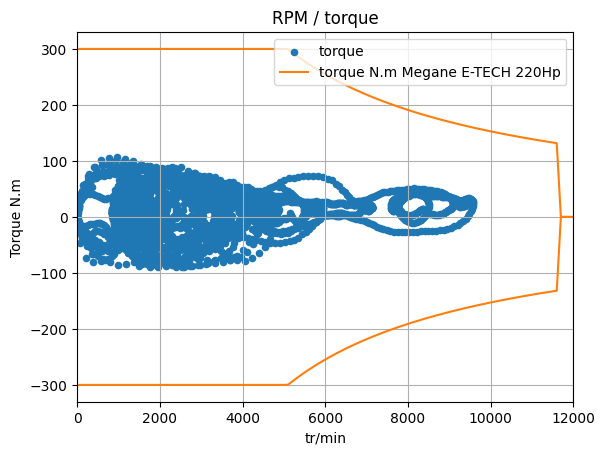

In [56]:
dfwltc.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.xlim([0,12000])
plt.grid()
plt.legend()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

In [57]:
dfwltc=dfwltc.astype('float32')

## NEDC Cycle

**Read the matlab/simulink results**

In [58]:
mat = scipy.io.loadmat('../matlabFiles/NEDC/nedc.mat')

**Select only variables that start with 'tws_...'**

In [59]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [60]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfNEDC=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfNEDC[c]=value
    
# Display the head of the DF
dfNEDC.head(2)

,time,tws_I_bat_ev,tws_Power_AC_ev,tws_Power_DC_ev,tws_Power_meca_ev,tws_Power_wheel_ev,tws_Ubat_ev,tws_acceleration_break,tws_acceleration_ev,tws_battery_power,...,tws_kmph_meas,tws_kmph_ref,tws_loss_INV_ev,tws_loss_batt_ev,tws_loss_body_ev,tws_loss_motor_ev,tws_road_grad,tws_soc_ev,tws_time,tws_torque_motor_ev
0,0.0,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,216000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,100.0,0.0,0.0
1,0.5,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,216000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,100.0,0.5,0.0


**Plot the speed: ref and measurement**

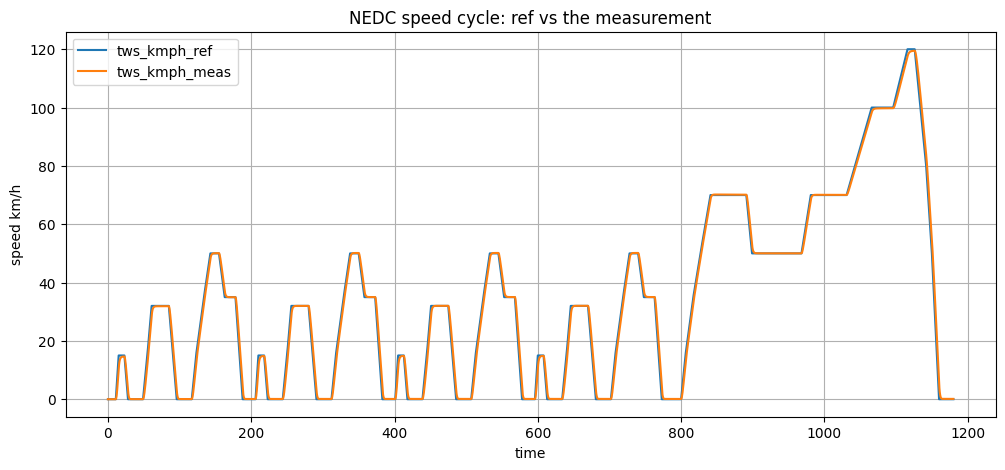

In [61]:
dfNEDC.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('NEDC speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

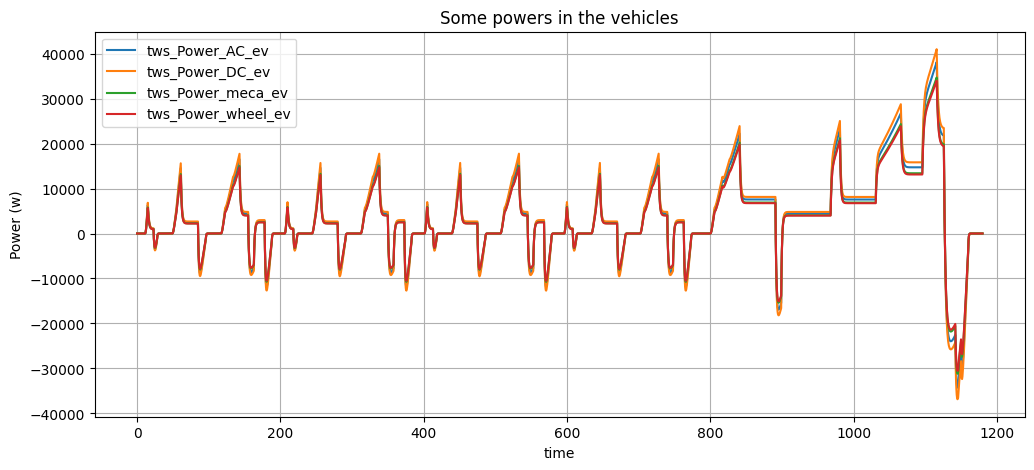

In [62]:
dfNEDC.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [63]:
dfNEDC.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

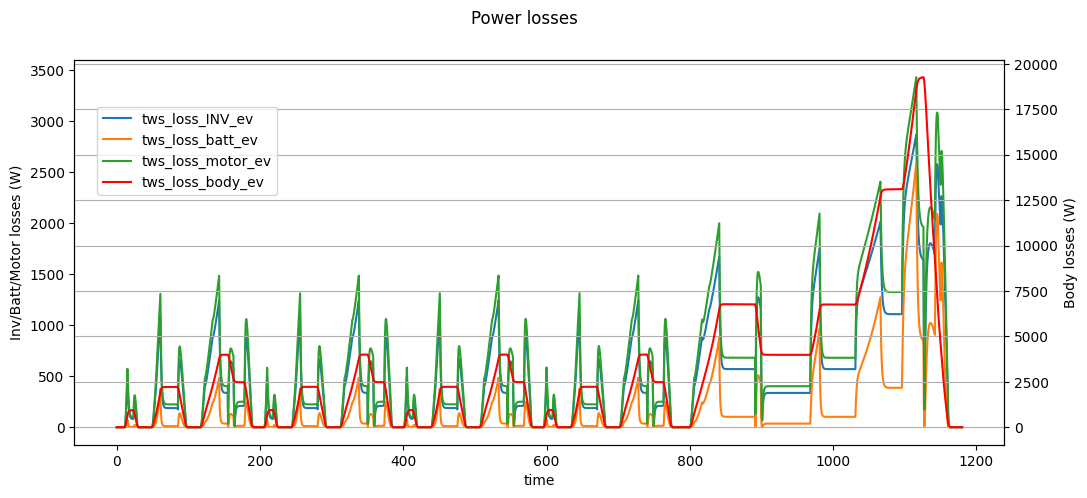

In [64]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfNEDC.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfNEDC.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

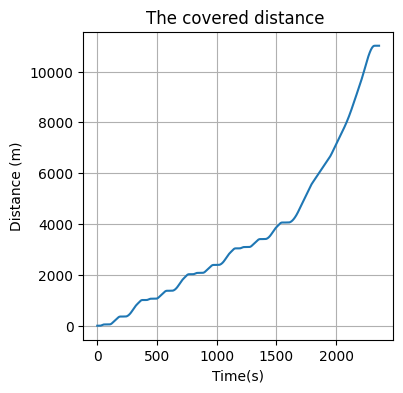

In [65]:
dfNEDC[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [66]:
delta_soc=dfNEDC['tws_soc_ev'].iloc[0]-dfNEDC['tws_soc_ev'].iloc[-1]
delta_dist=dfNEDC['tws_distance_ev'].iloc[-1]-dfNEDC[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the NEDC cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the NEDC cycle is:  525.38 km
The autonomy calculated by matlab is:  525.38 km


In [67]:
# Store the autonomy in the dic_auto dictionary
dic_auto['nedc']=autonomy

**Calculate the RPM**

In [68]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfNEDC['tws_rpm']=dfNEDC['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

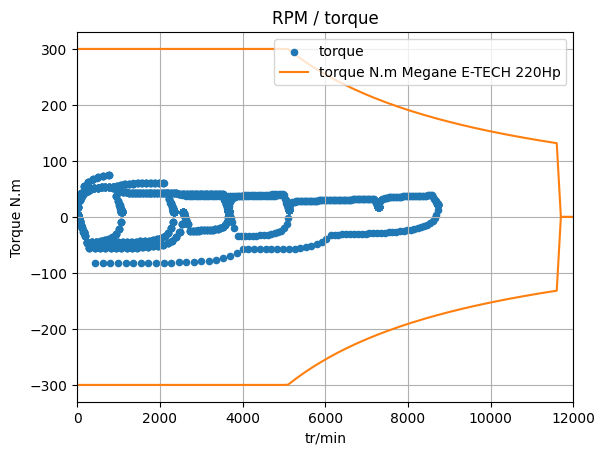

In [69]:
dfNEDC.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.legend()
plt.show()

In [70]:
dfNEDC=dfNEDC.astype('float32')

## Paris heigh way A5 225km

**Read the matlab/simulink results**

In [71]:
mat = scipy.io.loadmat('../matlabFiles/ParisA5_225km/parisA5_results.mat')

**Select only variables that start with 'tws_...'**

In [72]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [73]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfA5=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfA5[c]=value
    
# Display the head of the DF
dfA5.head(2)

,time,tws_I_bat_ev,tws_Power_AC_ev,tws_Power_DC_ev,tws_Power_meca_ev,tws_Power_wheel_ev,tws_Ubat_ev,tws_acceleration_break,tws_acceleration_ev,tws_battery_power,...,tws_kmph_meas,tws_kmph_ref,tws_loss_INV_ev,tws_loss_batt_ev,tws_loss_body_ev,tws_loss_motor_ev,tws_road_grad,tws_soc_ev,tws_time,tws_torque_motor_ev
0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,403.200000,0.262368,1.206972,2.160000e+08,...,0.000000,5.247364,0.000000,0.000000,0.000000,0.000000,0.0,100.000000,0.0,78.710461
1,0.5,2.290319,858.814692,923.456658,781.52137,765.890942,403.199971,0.198392,0.785154,2.159997e+08,...,1.716509,5.661534,64.641966,1.311391,107.003959,77.293322,0.0,99.999877,0.5,59.517665


**Plot the speed: ref and measurement**

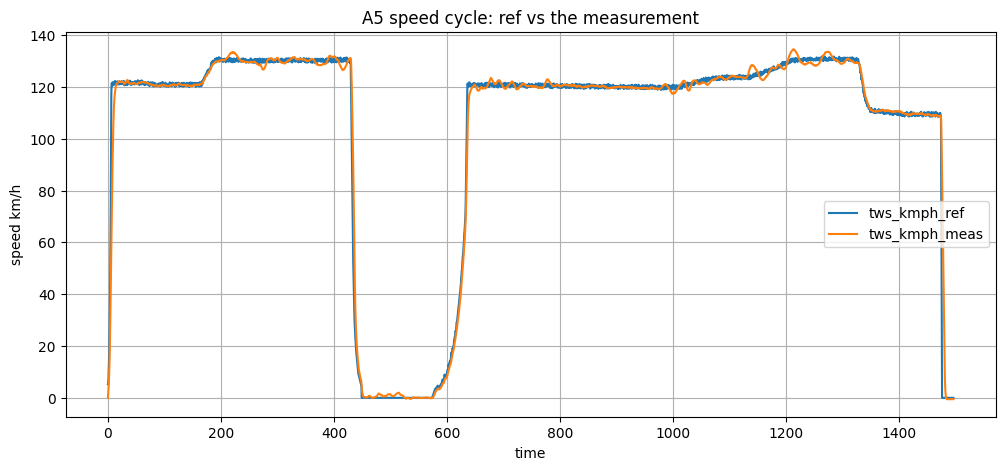

In [74]:
dfA5.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('A5 speed cycle: ref vs the measurement')
plt.show()

**Plot the different powers**

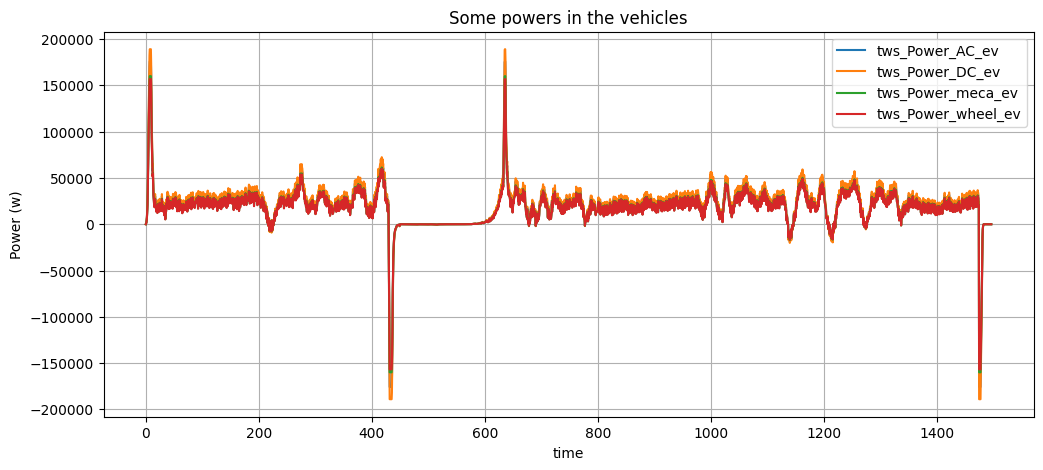

In [75]:
dfA5.plot(x='time', y=['tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev'],figsize=(12, 5))
plt.grid()
plt.ylabel('Power (w)')
plt.title('Some powers in the vehicles')
plt.show()

**Change some errors in the nomination of the columns**

In [76]:
dfA5.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the different losses**

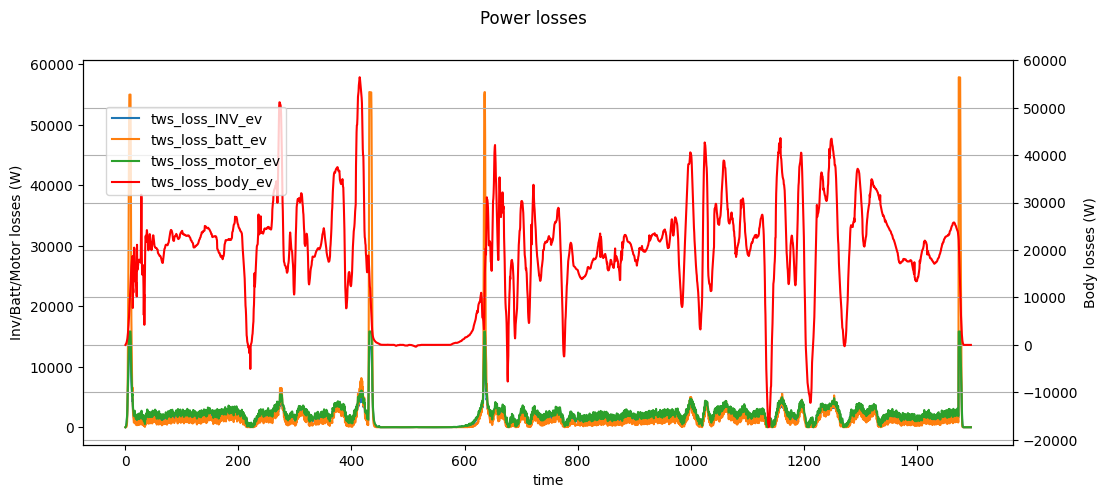

In [77]:
# Create a new figure with two y-axes
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()


# AX1 
dfA5.plot(x='time', y=['tws_loss_INV_ev',
                    'tws_loss_batt_ev', 
                    'tws_loss_motor_ev'],figsize=(12, 5),
           ax=ax1)
ax1.set_ylabel('Inv/Batt/Motor losses (W)')

# AX2
dfA5.plot(x='time', y=['tws_loss_body_ev'],
           ax=ax2,c='r')
ax2.set_ylabel('Body losses (W)')

# GENERAL SETTINGS
plt.suptitle('Power losses' )
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
fig.legend(loc='upper right', bbox_to_anchor=(0.3, 0.8))
plt.grid()
plt.show()

**Plot the covered distance**

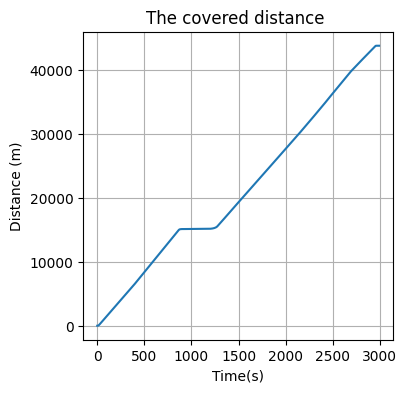

In [78]:
dfA5[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**The autonomy of this simulation**

In [79]:
delta_soc=dfA5['tws_soc_ev'].iloc[0]-dfA5['tws_soc_ev'].iloc[-1]
delta_dist=dfA5['tws_distance_ev'].iloc[-1]-dfA5[ 'tws_distance_ev'].iloc[0]
autonomy = 100*delta_dist/(delta_soc*1000)
matlab_auto=mat['autonomy'].item()
print('The autonomy of the A5 cycle is: ','{:.2f}'.format(autonomy),'km')
print('The autonomy calculated by matlab is: ',  '{:.2f}'.format(matlab_auto),'km')

The autonomy of the A5 cycle is:  283.14 km
The autonomy calculated by matlab is:  283.15 km


In [80]:
# Store the autonomy in the dic_auto dictionary
dic_auto['highway']=autonomy

**Calculate the RPM**

In [81]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfA5['tws_rpm']=dfA5['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

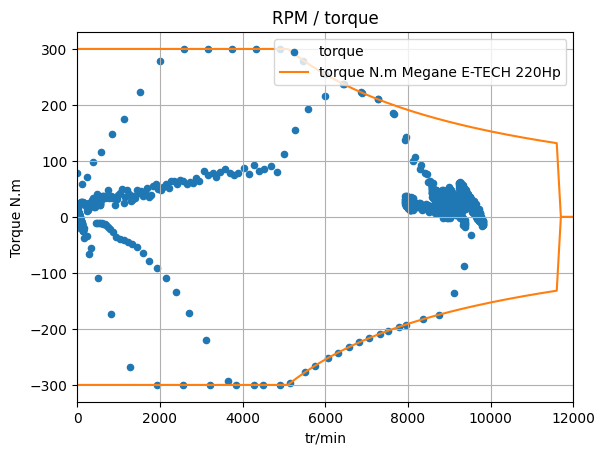

In [82]:
dfA5.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.legend()
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

In [83]:
dfA5=dfA5.astype('float32')

## The impact of speed on autonomy

**Read the matlab/simulink results**

In [84]:
mat = scipy.io.loadmat('../matlabFiles/speed_autonomy/speed_auto_results.mat')

**Select only variables that start with 'tws_...'**

In [85]:
cols=[x for x in mat.keys() if 'tws_' in x]

**Convert the selectionned variables to a dataFrame**

In [86]:
# Convert the selectionned variables to a dataFrame
c=cols[0]
# the time
time  = mat[c][0][0][0].flatten()
dfkmph_step=pd.DataFrame(time,columns=['time'])
# the other variables 
for c in cols:
    value = mat[c][0][0][1][0][0][0].flatten()
    dfkmph_step[c]=value
    
# Display the head of the DF
dfkmph_step.head(2)

,time,tws_I_bat_ev,tws_Power_AC_ev,tws_Power_DC_ev,tws_Power_meca_ev,tws_Power_wheel_ev,tws_Ubat_ev,tws_acceleration_break,tws_acceleration_ev,tws_battery_energy,...,tws_kmph_meas,tws_kmph_ref,tws_loss_INV_ev,tws_loss_batt_ev,tws_loss_body_ev,tws_loss_motor_ev,tws_road_grad,tws_soc_ev,tws_time,tws_torque_motor_ev
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,403.200000,1.0,4.600298,2.160000e+08,...,0.000000,30,0.000000,0.000000,0.000000,0.000000,0,100.000000,0.0,300.0
1,0.5,54.486782,20431.204693,21969.037305,18592.396271,18220.548345,403.199388,1.0,4.471882,2.159945e+08,...,8.101497,30,1537.832611,742.202364,508.623705,1838.808422,0,99.997449,0.5,300.0


**Plot the speed: ref and measurement**

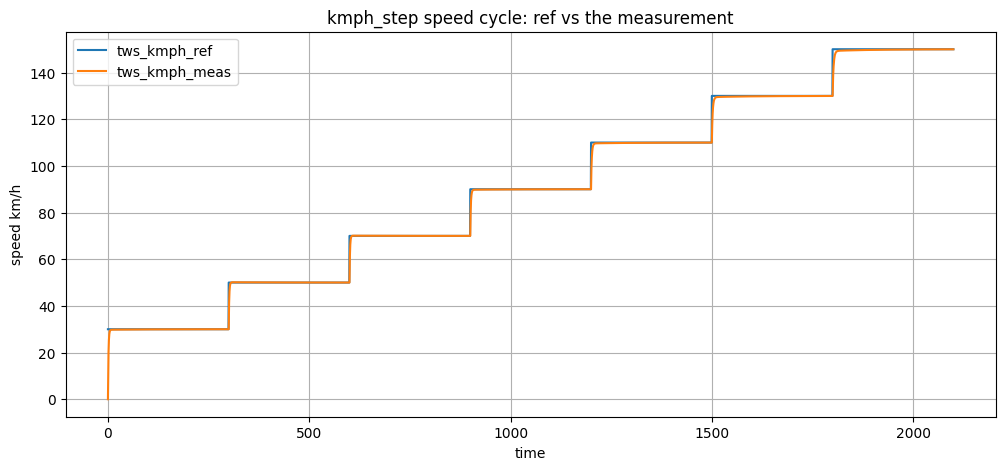

In [87]:
dfkmph_step.plot(x='time', y=['tws_kmph_ref','tws_kmph_meas'],figsize=(12, 5))
plt.grid()
plt.ylabel('speed km/h')
plt.title('kmph_step speed cycle: ref vs the measurement')
plt.show()

**Change some errors in the nomination of the columns**

In [88]:
dfkmph_step.rename({'tws_battery_power': 'tws_battery_energy_j',
              'rmp_2_kmph':'rpm_2_kmph'},axis=1,inplace=True)

**Plot the covered distance**

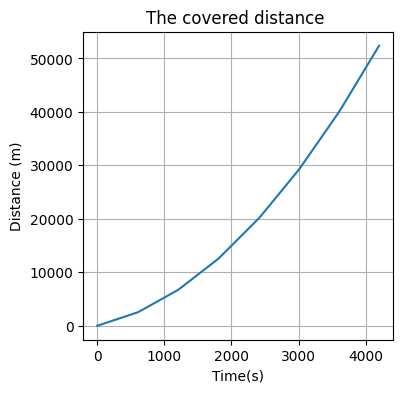

In [89]:
dfkmph_step[ 'tws_distance_ev'].plot(figsize=(4, 4))
plt.grid()
plt.ylabel('Distance (m)')
plt.xlabel('Time(s)')
plt.title('The covered distance ')
plt.show()

**Calculate the RPM**

In [90]:
rpm_2_kmph=mat['rmp_2_kmph'].item()
dfkmph_step['tws_rpm']=dfkmph_step['tws_kmph_meas']/rpm_2_kmph

**Plot the RPM / torque**

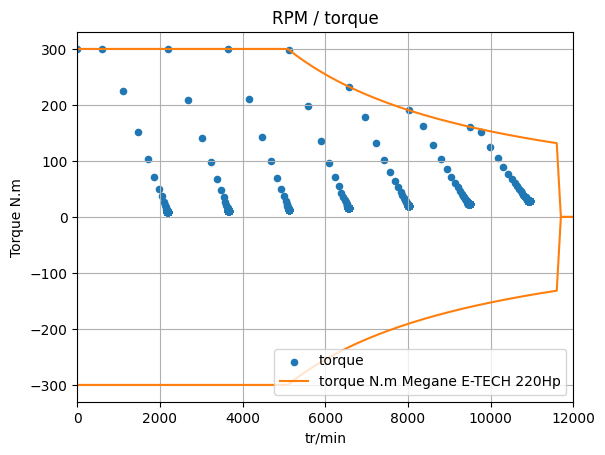

In [91]:
dfkmph_step.plot(x='tws_rpm',y='tws_torque_motor_ev',kind='scatter',c='C0',label='torque')
plt.plot(motor_speed_rpmPM,motor_torquePM,label='torque N.m Megane E-TECH 220Hp',c='C1')
plt.plot(motor_speed_rpmPM,-motor_torquePM,c='C1')
plt.legend()
plt.xlim([0,12000])
plt.grid()
plt.xlabel('tr/min')
plt.ylabel('Torque N.m')
plt.title('RPM / torque')
plt.show()

**Calculate autonomy by speed**

In [92]:
# - speed_step: Step size for speed calculations
speed_step=mat['speed_step'][0][0]
# - sim_time: Total simulation time
sim_time=mat['sim_time'][0][0]
# - Ts: Time step
Ts=mat['Ts'][0][0]
# - n_step: Number of simulation steps
n_step=int(sim_time/(speed_step*Ts))
# - i: Index for iteration
i=int(0.98*speed_step/Ts)
# - di: Index for delta calculations
di=int(0.5*speed_step/Ts)

speed_step, sim_time,Ts, n_step,i,di
auto_list = []  

# List to store results
while i < sim_time / Ts:
    # Calculate change in state of charge (delta_soc)
    delta_soc = dfkmph_step.loc[i - di : i, 'tws_soc_ev']
    delta_soc = delta_soc.iloc[0] - delta_soc.iloc[-1]

    # Calculate change in distance (delta_dist)
    delta_dist = dfkmph_step.loc[i - di : i, 'tws_distance_ev']
    delta_dist = delta_dist.iloc[-1] - delta_dist.iloc[0]

    # Calculate autonomy (distance covered per unit SOC)
    autonomy = 100 * delta_dist / (delta_soc * 1000)

    # Calculate average speed (kmph)
    kmph = dfkmph_step.loc[i - di : i, 'tws_kmph_meas'].mean()

    # Append results to the auto_list
    auto_list.append({"kmph": kmph, "autonomy": autonomy})
    i += int(speed_step / Ts)


In [93]:
dfauto=pd.DataFrame(auto_list)#.plot.bar(x='kmph',y='autonomy')
dfauto.kmph= (dfauto.kmph+0.5).astype(int)
dfauto

,kmph,autonomy
0,30,725.536021
1,50,624.870433
2,70,516.899120
3,90,420.116752
4,110,340.486424
5,130,277.409475
6,150,228.123454


In [94]:
for i in range(len(dfauto)):
    kmph=dfauto.loc[i,'kmph']
    autonomy=dfauto.loc[i,'autonomy']
    dic_auto[str(kmph)+'km/h']=autonomy

**Plot the autonomy vs speed**

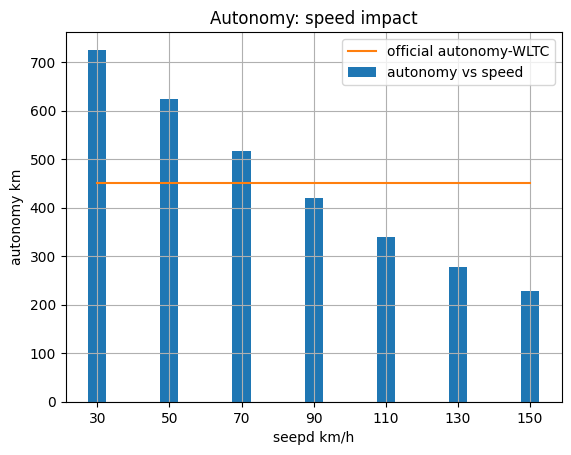

In [95]:
plt.bar(dfauto.kmph,dfauto.autonomy,width=5,label='autonomy vs speed')
# AUTO 450 # https://cdn.group.renault.com/ren/fr/product-plans/brochures/megane-e-tech-electrique/brochure-megane-electrique.pdf.asset.pdf/6614df6f13.pdf
plt.plot([30,150],[450,450],c='C1',label='official autonomy-WLTC')

plt.xticks(range(30,160,20))
plt.legend()
plt.grid()
plt.ylabel('autonomy km')
plt.xlabel('seepd km/h')
plt.title('Autonomy: speed impact')
plt.show()

plt.show()

In [96]:
dfkmph_step=dfkmph_step.astype('float32')

## Comparaison

In [97]:
# Dcitonary to dataFrame
dic_auto_s=pd.Series(dic_auto)

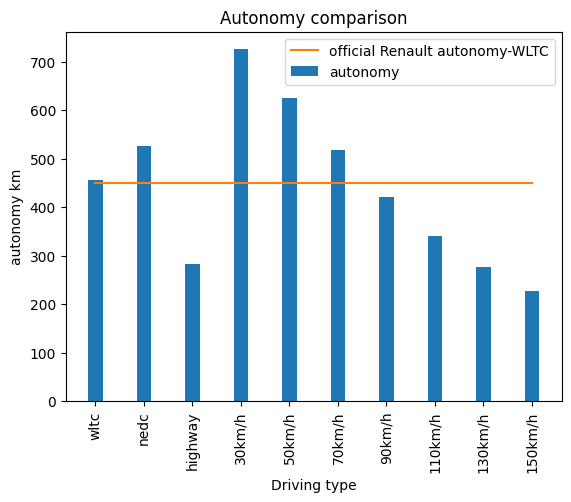

In [98]:
# Bar plot

plt.bar(dic_auto_s.index,dic_auto_s.values,width=0.3,label='autonomy')

# AUTO 450 # https://cdn.group.renault.com/ren/fr/product-plans/brochures/megane-e-tech-electrique/brochure-megane-electrique.pdf.asset.pdf/6614df6f13.pdf
n=len(dic_auto_s.index)
plt.plot([450]*n,c='C1',label='official Renault autonomy-WLTC')

plt.xticks(dic_auto_s.index)
plt.legend()
#plt.grid()
plt.ylabel('autonomy km')
plt.xlabel('Driving type')
plt.title('Autonomy comparison')
plt.xticks(rotation=90)
plt.show()

We can see that the autonomy depend a lot of the speed of the vehicle, in general a high speed reduce the autonomy of an electric car.
<br> 
This can be explained by the fact of the cubic relation between the drag loss and car speed.
<br> 
In general, an electrical car is good for the city uses, but not in the highway uses 

## Save the data

**drop the duplicated columns**

In [99]:
listdf=[dfwltc, dfNEDC, dfA5 ,dfkmph_step]

for df in listdf:
    #the time column is duplicated: 'time' and 'tws_time' 
    df.drop('time',axis=1,inplace=True)

**Rename columns**

In [100]:
dfwltc.columns

Index(['tws_I_bat_ev', 'tws_Power_AC_ev', 'tws_Power_DC_ev',
       'tws_Power_meca_ev', 'tws_Power_wheel_ev', 'tws_Ubat_ev',
       'tws_acceleration_break', 'tws_acceleration_ev', 'tws_battery_energy_j',
       'tws_distance_ev', 'tws_kmph_meas', 'tws_kmph_ref', 'tws_loss_INV_ev',
       'tws_loss_batt_ev', 'tws_loss_body_ev', 'tws_loss_motor_ev',
       'tws_road_grad', 'tws_soc_ev', 'tws_time', 'tws_torque_motor_ev',
       'tws_rpm'],
      dtype='object')

In [101]:
cols=dfwltc.columns
newcols=[x.replace('tws_','') for x in cols]
dic_cols={x:y for (x,y) in zip(cols, newcols)}
print(dic_cols)

{'tws_I_bat_ev': 'I_bat_ev', 'tws_Power_AC_ev': 'Power_AC_ev', 'tws_Power_DC_ev': 'Power_DC_ev', 'tws_Power_meca_ev': 'Power_meca_ev', 'tws_Power_wheel_ev': 'Power_wheel_ev', 'tws_Ubat_ev': 'Ubat_ev', 'tws_acceleration_break': 'acceleration_break', 'tws_acceleration_ev': 'acceleration_ev', 'tws_battery_energy_j': 'battery_energy_j', 'tws_distance_ev': 'distance_ev', 'tws_kmph_meas': 'kmph_meas', 'tws_kmph_ref': 'kmph_ref', 'tws_loss_INV_ev': 'loss_INV_ev', 'tws_loss_batt_ev': 'loss_batt_ev', 'tws_loss_body_ev': 'loss_body_ev', 'tws_loss_motor_ev': 'loss_motor_ev', 'tws_road_grad': 'road_grad', 'tws_soc_ev': 'soc_ev', 'tws_time': 'time', 'tws_torque_motor_ev': 'torque_motor_ev', 'tws_rpm': 'rpm'}


In [102]:
for df in listdf:
    df.rename(dic_cols,axis=1,inplace=True)

In [103]:
dfwltc.columns

Index(['I_bat_ev', 'Power_AC_ev', 'Power_DC_ev', 'Power_meca_ev',
       'Power_wheel_ev', 'Ubat_ev', 'acceleration_break', 'acceleration_ev',
       'battery_energy_j', 'distance_ev', 'kmph_meas', 'kmph_ref',
       'loss_INV_ev', 'loss_batt_ev', 'loss_body_ev', 'loss_motor_ev',
       'road_grad', 'soc_ev', 'time', 'torque_motor_ev', 'rpm'],
      dtype='object')

**add session ID**

In [104]:
sessions=['WLTC', 'NEDC','Highway' ,'speed_steps']
for (df,s) in zip(listdf,sessions):
    df['session']=s

**Concatenate the 4 dataFrame**

In [105]:
df=pd.concat(listdf,axis=0).reset_index(drop=True)
df.head(2)

,I_bat_ev,Power_AC_ev,Power_DC_ev,Power_meca_ev,Power_wheel_ev,Ubat_ev,acceleration_break,acceleration_ev,battery_energy_j,distance_ev,...,loss_batt_ev,loss_body_ev,loss_motor_ev,road_grad,soc_ev,time,torque_motor_ev,rpm,session,tws_battery_energy
0,0.0,0.0,0.0,0.0,0.0,403.200012,0.0,0.0,216000000.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,WLTC,NaN
1,0.0,0.0,0.0,0.0,0.0,403.200012,0.0,0.0,216000000.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.5,0.0,0.0,WLTC,NaN


In [106]:
df.shape

(13156, 23)

**Correct the battery energy**

In [107]:
df.drop(['tws_battery_energy', 'battery_energy_j'],axis=1,inplace=True)

In [108]:
bat_energy_kwh=mat['bat_energy_kwh'].item()
df['bat_energy_kwh']=df.soc_ev*bat_energy_kwh/100

**Verifay the dataFrame**

In [109]:
df.isna().sum()

I_bat_ev              0
Power_AC_ev           0
Power_DC_ev           0
Power_meca_ev         0
Power_wheel_ev        0
Ubat_ev               0
acceleration_break    0
acceleration_ev       0
distance_ev           0
kmph_meas             0
kmph_ref              0
loss_INV_ev           0
loss_batt_ev          0
loss_body_ev          0
loss_motor_ev         0
road_grad             0
soc_ev                0
time                  0
torque_motor_ev       0
rpm                   0
session               0
bat_energy_kwh        0
dtype: int64

In [110]:
df.shape

(13156, 22)

In [111]:
df.columns

Index(['I_bat_ev', 'Power_AC_ev', 'Power_DC_ev', 'Power_meca_ev',
       'Power_wheel_ev', 'Ubat_ev', 'acceleration_break', 'acceleration_ev',
       'distance_ev', 'kmph_meas', 'kmph_ref', 'loss_INV_ev', 'loss_batt_ev',
       'loss_body_ev', 'loss_motor_ev', 'road_grad', 'soc_ev', 'time',
       'torque_motor_ev', 'rpm', 'session', 'bat_energy_kwh'],
      dtype='object')

**Save the dataFrame**

In [112]:
df.to_csv('../data/output/MEGANE_E_TECH_EV60_220_driv_data.csv',index=False)

## Download dataset

**Download the dataset asDirectly by pandas csv reading as a csv file from the [link](https://github.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/blob/main/data/output/MEGANE_E_TECH_EV60_220_driv_data.csv)** <br>


**Directly by pandas csv reading as**

In [120]:
# read raw data 
url='https://raw.githubusercontent.com/bouz1/EV_Matlab_Simulink_Megane_E_TECH_to_generate_data/main/data/output/MEGANE_E_TECH_EV60_220_driv_data.csv'
df_read=pd.read_csv(url)
# display the head 
df_read.head(2)

,I_bat_ev,Power_AC_ev,Power_DC_ev,Power_meca_ev,Power_wheel_ev,Ubat_ev,acceleration_break,acceleration_ev,distance_ev,kmph_meas,...,loss_batt_ev,loss_body_ev,loss_motor_ev,road_grad,soc_ev,time,torque_motor_ev,rpm,session,bat_energy_kwh
0,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,WLTC,60.0
1,0.0,0.0,0.0,0.0,0.0,403.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.5,0.0,0.0,WLTC,60.0


**From kaggle**

In [136]:
TBCompleted

NameError: name 'TBCompleted' is not defined

## Dataset exploration

**Columns description**

* I_bat_ev : The HV battery current [A]
* Power_AC_ev : The AC power, transferred from the inverter to the motor [W]
* Power_DC_ev : The DC power, transferred from the battery to the inverter [W]
* Power_meca_ev : The mechanical power, the output of the motor [W]
* Power_wheel_ev : The mechanical power, in the output of the motor reductor [W]
* Ubat_ev : The battery DC voltage [V]
* acceleration_break : The acceleration/break command, range [-1,1], [-1,0] : break, [0,1] : acceleration
* acceleration_ev : The acceleration the EV [m/s2]
* distance_ev : The distance of the EV [m]
* kmph_meas : The speed of the EV [km/h]
* kmph_ref : The speed reference of the EV [km/h]
* loss_INV_ev : The power loss of the inverter [W]
* loss_batt_ev : The power loss of the battery [W]
* loss_body_ev : The power loss of the vehicle body (drag, rolling, ...) [W]
* loss_motor_ev : The power loss of the motor [W]
* road_grad : The road gradient [°]
* soc_ev : The battery state of charge (soc) [ %]
* time : The time [s]
* torque_motor_ev : The motor torque [N.m]
* rpm : The motor speed [tr/min]
* session : The simulation session, NEDC cyle, WLTC cyle, Highway driving, the step speed driving
* bat_energy_kwh : the battery energy [kWh]

**The dataset description: min / max / mean ...**

In [130]:
df_read.describe([0.05,0.5,0.95])

,I_bat_ev,Power_AC_ev,Power_DC_ev,Power_meca_ev,Power_wheel_ev,Ubat_ev,acceleration_break,acceleration_ev,distance_ev,kmph_meas,kmph_ref,loss_INV_ev,loss_batt_ev,loss_body_ev,loss_motor_ev,road_grad,soc_ev,time,torque_motor_ev,rpm,bat_energy_kwh
count,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000,13156.000000
mean,32.442944,12064.418988,12972.493545,10978.621286,10759.048849,401.516020,0.074985,0.007270,14002.577855,71.357015,71.417419,1087.679875,808.541786,10503.662911,1300.554366,0.026389,96.042984,857.685011,15.070711,5212.629943,57.625790
std,46.709617,17348.127051,18653.900148,15786.795739,15471.059799,2.677987,0.117583,0.417998,13209.424008,47.287899,47.371650,1160.417074,3112.378082,10527.353469,1387.527275,0.452411,4.433095,531.571081,28.692136,3454.381048,2.659857
min,-481.082670,-175824.170000,-189058.250000,-160000.000000,-156800.000000,392.318050,-1.000000,-4.911469,0.000000,-1.323811,0.000000,0.000000,0.000000,-17358.277000,0.000000,-3.724392,83.219505,0.000000,-300.000000,-96.704410,49.931705
5%,-19.296253,-7231.250100,-7775.538075,-6580.437750,-6448.829175,394.473950,-0.111309,-0.649117,573.458708,0.065305,0.000000,0.161338,0.000008,1.582079,0.192914,-0.335422,85.910361,82.000000,-30.403233,4.770514,51.546214
50%,24.074572,8988.260250,9664.795500,8179.316650,8015.730500,402.709650,0.067963,0.000142,9433.445000,70.018890,70.000000,868.953850,237.829635,6740.904850,1039.020500,0.000000,97.935245,822.000000,15.800339,5114.879900,58.761149
95%,100.116999,36667.457000,39427.375000,33367.387000,32700.038500,403.175178,0.212428,0.594538,41956.697500,132.904573,131.081485,2760.257450,2509.268375,32598.184500,3300.479425,0.759726,99.896541,1785.625000,50.542066,9708.679500,59.937924
max,475.829380,175824.170000,189058.250000,160000.000000,156800.000000,403.200000,1.000000,4.600298,52385.240000,149.958130,150.000000,13234.078000,57860.133000,56433.363000,15824.176000,3.249308,100.000000,2100.000000,300.000000,10954.441000,60.000000
